In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numpy as np
import keras
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog

2024-01-09 09:29:19.693059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
SEED = 172024
random.seed(SEED)

In [4]:
BASE_DIR_PATH = os.path.abspath(os.getcwd())
DATA_BASE_DIR = BASE_DIR_PATH + '/data/'

In [5]:
OG_CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original'
OG_CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Car'
OG_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Bike'

CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned'
CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Car'
BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Bike'

In [6]:
# total number of images in dataset
len(os.listdir(OG_CAR_DIR) + os.listdir(OG_BIKE_DIR))

4000

Clean up image mode and format of image files

In [7]:
# create clean Car image set
for i, f in enumerate(sorted(os.listdir(OG_CAR_DIR))):
    i = i + 1
    im = Image.open(OG_CAR_DIR + '/' + f.strip())
    new_file_name =  CAR_DIR + f'/Car-{i}.png'
    # check if is not RGB
    if im.mode != 'RGB':
        # convert to RGB and save as PNG
        rgb_im = im.convert("RGB")
        rgb_im.save(new_file_name, format='PNG')
    else:
        im.save(new_file_name, format='PNG')

# create clean Bike image set
for i, f in enumerate(sorted(os.listdir(OG_BIKE_DIR))):
    i = i + 1
    im = Image.open(OG_BIKE_DIR + '/' + f.strip())
    new_file_name = BIKE_DIR + f'/Bike-{i}.png'
    # check if is not RGB
    if im.mode != 'RGB':
        # convert to RGB and save as PNG
        rgb_im = im.convert("RGB")
        rgb_im.save(new_file_name, format='PNG')
    else:
        im.save(new_file_name, format='PNG')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


**Cars = 0 and Bikes = 1**

In [8]:
files = []
for f in sorted(os.listdir(CAR_DIR)):
    files.append([CAR_DIR + '/' + f, 0])
for f in sorted(os.listdir(BIKE_DIR)):
    files.append([BIKE_DIR + '/' + f, 1])
files = np.array(files)

View distribution of Cars vs Bikes

In [9]:
files.shape, pd.Series(files[:, 1]).value_counts()

((4000, 2),
 0    2000
 1    2000
 dtype: int64)

The dataset is perfectly balanced between Cars and Bikes.

In [10]:
df_img_files = pd.DataFrame(files, columns=['img_file', 'label'])

In [11]:
df_img_files.head(2)

,img_file,label
0,/Users/Tarek/Documents/masterRootAppFolder/Exp...,0
1,/Users/Tarek/Documents/masterRootAppFolder/Exp...,0


In [12]:
def create_df_img(df, img_scale, interpolation='lanczos'):
    pil_imgs = []
    preprocessed_imgs = []
    flattened_imgs = []
    for i in range(len(df)):
        img_file = df['img_file'][i]
        img = image.load_img(img_file.strip(), target_size=(img_scale, img_scale), interpolation=interpolation)
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)
        preprocessed_imgs.append(x)
        flat_img = x.flatten()
        flattened_imgs.append(flat_img)
        pil_imgs.append(img)
    pil_imgs = np.array(pil_imgs)
    preprocessed_imgs = np.array(preprocessed_imgs)
    flattened_imgs = np.array(flattened_imgs)
    data = np.array([np.array([pil_imgs[i], preprocessed_imgs[i], flattened_imgs[i]], dtype=object) for i in range(len(pil_imgs))])
    columns=['pil_imgs', 'preprocessed_imgs', 'flattened_imgs']
    return pd.DataFrame(data, columns=columns)

In [16]:
def create_df_hog(df, img_scale, interpolation='lanczos'):
    records = []
    name = lambda label : 'Car' if label == 0 else 'Bike'
    for i in range(len(df)):
        img_file, label = df['img_file'][i], df['label'][i]
        # unique identifier
        id = f'{i}-{name(label)}'
        # PIL, np_img, flat_img
        img = image.load_img(img_file.strip(), target_size=(img_scale, img_scale), interpolation=interpolation)
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)
        flat_img = x.flatten()
        # HOG
        hog_fd, hog_img = hog(
            image=np.array(img),
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            visualize=True,
            channel_axis=2
        )
        record = np.array([id, img, x, flat_img, hog_fd, hog_img, label], dtype=object)
        records.append(record)
    columns=['id', 'pil_img', 'np_img', 'flat_img', 'hog_fd', 'hog_img', 'label']
    return pd.DataFrame(data=records, columns=columns)

### Creating 16x16 Image & HOG Dataset

In [22]:
df_img_16 = create_df_img(
    df=df_img_files,
    img_scale=16,
    interpolation='lanczos'
)

In [23]:
df_img_16.head(2)

,pil_imgs,preprocessed_imgs,flattened_imgs
0,"[[[117, 24, 25], [128, 26, 32], [134, 28, 33],...","[[[[-0.08235294 -0.8117647 -0.8039216 ], [ 0....","[-0.082352936, -0.8117647, -0.8039216, 0.00392..."
1,"[[[252, 243, 223], [253, 246, 229], [254, 248,...","[[[[0.9764706 0.90588236 0.7490196 ], [0.9843...","[0.9764706, 0.90588236, 0.7490196, 0.9843137, ..."


In [36]:
np.save(file=CAR_BIKE_DIR + '/16/df_img_16.npy', arr=df_img_16.to_numpy(), allow_pickle=True)

In [18]:
df_hog_16 = create_df_hog(
    df=df_img_files,
    img_scale=16,
    interpolation='lanczos'
)

In [21]:
df_hog_16.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=16x16 at ...,"[[[[-0.08235294 -0.8117647 -0.8039216 ], [ 0....","[-0.082352936, -0.8117647, -0.8039216, 0.00392...","[0.03356156701196681, 0.08052361489542241, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=16x16 at ...,"[[[[0.9764706 0.90588236 0.7490196 ], [0.9843...","[0.9764706, 0.90588236, 0.7490196, 0.9843137, ...","[0.01362145992780334, 0.0, 0.00405108563687190...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [20]:
np.save(file=CAR_BIKE_DIR + '/16/df_hog_16.npy', arr=df_hog_16.to_numpy(), allow_pickle=True)

### Creating 32x32 Image Dataset

In [28]:
df_img_32 = create_df_img(
    df=df_img_files,
    img_scale=32,
    interpolation='lanczos'
)

In [29]:
df_img_32.head(2)

,pil_imgs,preprocessed_imgs,flattened_imgs
0,"[[[167, 35, 38], [174, 36, 43], [179, 36, 47],...","[[[[ 0.30980396 -0.7254902 -0.7019608 ], [ 0....","[0.30980396, -0.7254902, -0.7019608, 0.3647059..."
1,"[[[252, 242, 222], [252, 244, 225], [253, 245,...","[[[[0.9764706 0.8980392 0.7411765], [0.9764706...","[0.9764706, 0.8980392, 0.7411765, 0.9764706, 0..."


In [37]:
np.save(file=CAR_BIKE_DIR + '/32/df_img_32.npy', arr=df_img_32.to_numpy(), allow_pickle=True)

In [24]:
df_hog_32 = create_df_hog(
    df=df_img_files,
    img_scale=32,
    interpolation='lanczos'
)

In [25]:
df_hog_32.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=32x32 at ...,"[[[[ 0.30980396 -0.7254902 -0.7019608 ], [ 0....","[0.30980396, -0.7254902, -0.7019608, 0.3647059...","[0.03865292168975405, 0.0, 0.0, 0.0, 0.3401712...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=32x32 at ...,"[[[[0.9764706 0.8980392 0.7411765], [0.9764706...","[0.9764706, 0.8980392, 0.7411765, 0.9764706, 0...","[0.0589068554210715, 0.0, 0.026773553866190656...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [27]:
np.save(file=CAR_BIKE_DIR + '/32/df_hog_32.npy', arr=df_hog_32.to_numpy(), allow_pickle=True)

### Creating 64x64 Image Dataset

In [30]:
df_img_64 = create_df_img(
    df=df_img_files,
    img_scale=64,
    interpolation='lanczos'
)

In [31]:
df_img_64.head(2)

,pil_imgs,preprocessed_imgs,flattened_imgs
0,"[[[178, 33, 38], [177, 30, 37], [180, 32, 42],...","[[[[ 0.39607847 -0.7411765 -0.7019608 ], [ 0....","[0.39607847, -0.7411765, -0.7019608, 0.3882353..."
1,"[[[252, 241, 220], [252, 242, 222], [252, 244,...","[[[[0.9764706 0.8901961 0.7254902], [0.9764706...","[0.9764706, 0.8901961, 0.7254902, 0.9764706, 0..."


In [38]:
np.save(file=CAR_BIKE_DIR + '/64/df_img_64.npy', arr=df_img_64.to_numpy(), allow_pickle=True)

In [32]:
df_hog_64 = create_df_hog(
    df=df_img_files,
    img_scale=64,
    interpolation='lanczos'
)

In [33]:
df_hog_64.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=64x64 at ...,"[[[[ 0.39607847 -0.7411765 -0.7019608 ], [ 0....","[0.39607847, -0.7411765, -0.7019608, 0.3882353...","[0.021065038310983747, 0.0, 0.0, 0.00379861752...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=64x64 at ...,"[[[[0.9764706 0.8901961 0.7254902], [0.9764706...","[0.9764706, 0.8901961, 0.7254902, 0.9764706, 0...","[0.31825621275498656, 0.04297539893275055, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [34]:
np.save(file=CAR_BIKE_DIR + '/64/df_hog_64.npy', arr=df_hog_64.to_numpy(), allow_pickle=True)

### Creating 128x128 Image Dataset

In [35]:
df_img_128 = create_df_img(
    df=df_img_files,
    img_scale=128,
    interpolation='lanczos'
)

In [36]:
df_img_128.head(2)

,pil_imgs,preprocessed_imgs,flattened_imgs
0,"[[[189, 42, 48], [187, 39, 45], [183, 34, 42],...","[[[[ 0.48235297 -0.67058825 -0.62352943], [ 0....","[0.48235297, -0.67058825, -0.62352943, 0.46666..."
1,"[[[252, 241, 219], [252, 241, 221], [253, 242,...","[[[[0.9764706 0.8901961 0.7176471], [0.9764706...","[0.9764706, 0.8901961, 0.7176471, 0.9764706, 0..."


In [39]:
np.save(file=CAR_BIKE_DIR + '/128/df_img_128.npy', arr=df_img_128.to_numpy(), allow_pickle=True)

In [37]:
df_hog_128 = create_df_hog(
    df=df_img_files,
    img_scale=128,
    interpolation='lanczos'
)

In [38]:
df_hog_128.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=128x128 a...,"[[[[ 0.48235297 -0.67058825 -0.62352943], [ 0....","[0.48235297, -0.67058825, -0.62352943, 0.46666...","[0.02841042031673197, 0.0, 0.02979214472028403...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=128x128 a...,"[[[[0.9764706 0.8901961 0.7176471], [0.9764706...","[0.9764706, 0.8901961, 0.7176471, 0.9764706, 0...","[0.36116382231056576, 0.16252009356534228, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [39]:
np.save(file=CAR_BIKE_DIR + '/128/df_hog_128.npy', arr=df_hog_128.to_numpy(), allow_pickle=True)

Same image but different scales: 16, 32, 64, 128.

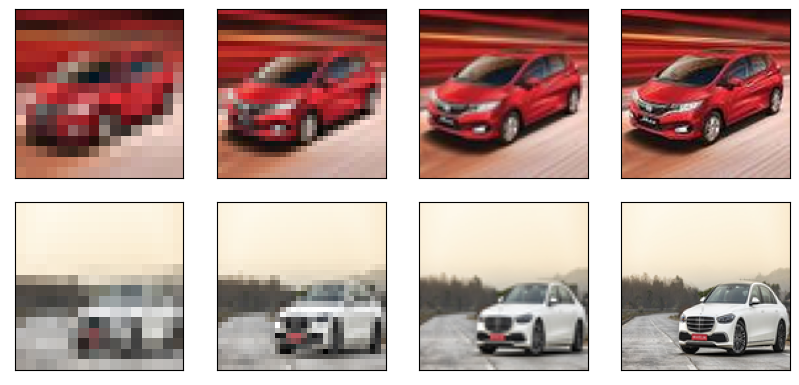

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

ax[0, 0].imshow(df_img_16['pil_imgs'][0])
ax[0, 1].imshow(df_img_32['pil_imgs'][0])
ax[0, 2].imshow(df_img_64['pil_imgs'][0])
ax[0, 3].imshow(df_img_128['pil_imgs'][0])
ax[1, 0].imshow(df_img_16['pil_imgs'][1])
ax[1, 1].imshow(df_img_32['pil_imgs'][1])
ax[1, 2].imshow(df_img_64['pil_imgs'][1])
ax[1, 3].imshow(df_img_128['pil_imgs'][1])

# remove tick labels
for i in range(2):
    for j in range(4):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])

fig.subplots_adjust(hspace=0)

plt.show()

In [47]:
df_hog_128['hog_fd'][0].shape, df_hog_128['hog_img'][0].shape

((8100,), (128, 128))

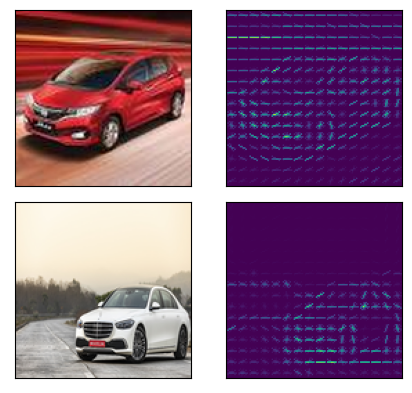

In [94]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

ax[0, 0].imshow(df_hog_128['pil_img'][0])
ax[0, 1].imshow(df_hog_128['hog_img'][0])
ax[1, 0].imshow(df_hog_128['pil_img'][1])
ax[1, 1].imshow(df_hog_128['hog_img'][1])

# remove tick labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])

fig.subplots_adjust(hspace=0)

plt.show()

Will use the rest of code in another file later...

In [ ]:
columns_names = ['img', 'label']

img_32_array = np.load(BASE_DIR_PATH + '', allow_pickle=True)
img_32_df = pd.DataFrame(img_32_array)

In [ ]:
# create HOG Dataframes
hog_img_32_array = []
img_scale = 32

for i in range(len(img_32_df)):
    img, label = img_32_df['img'][i], img_32_df['label'][i]
    hog_fd, hog_img = hog(
        image=np.array(preprocess_input).reshape(img_scale, img_scale,3),
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        visualize=True,
        channel_axis=2
    )
    hog_img_32_array.append(img, hog_fd, hog_img, label)

hog_img_32_array = np.array(hog_img_32_array)

In [ ]:
hog_column_names = ['img', 'hog_fd', 'hog_img', 'label']

hog_img_32_df = pd.DataFrame(hog_img_32_array, columns=hog_column_names)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_model_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class

    class_0_accuracy = accuracies_per_class[0]
    class_1_accuracy = accuracies_per_class[1]

    metrics = (acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy)
    return metrics

In [ ]:
from sklearn.model_selection import StratifiedKFold

def k_fold_scores(model, df_img, df_hog_img, model_name=None, n_splits=10, seed=12172023) -> dict:

    random.seed(seed)

    rand_list = random.sample(range(0, len(df_img)), len(df_img))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    k_fold_results = {}

    # Vectorized images
    randomized_imgs = []

    # shuffle records according to rand_list
    for i in range(len(df_img)):
        ind = rand_list[i]
        flat_img, outcome = df_img['flat_img_array'][ind], df_img['outcome'][ind]
        randomized_imgs.append(np.array([flat_img, outcome]))

    randomized_imgs = np.array(randomized_imgs)

    X, y = randomized_imgs[:, 0], randomized_imgs[:, 1]

    wide_X = np.zeros((len(X), X[0].shape[0]))
    for indx in range(len(X)):
        for feature in range(X[0].shape[0]):
            wide_X[indx][feature] = X[indx][feature]
    
    y = y.astype(int)

    # Vectorized Stratified K-Fold
    acc_scores = []
    prec_scores = []
    recall_scores = []
    f1_scores = []
    roc_scores = []
    class_0_acc_scores = []
    class_1_acc_scores = []

    for train_indx, test_indx in skf.split(wide_X, y):
        X_train, X_test = wide_X[train_indx], wide_X[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy = get_model_scores(y_test, y_pred)
        acc_scores.append(acc); prec_scores.append(prec)
        recall_scores.append(recall); f1_scores.append(f1)
        roc_scores.append(roc); class_0_acc_scores.append(class_0_accuracy)
        class_1_acc_scores.append(class_1_accuracy)

    avg_acc = np.mean(acc_scores)
    avg_prec_scores = np.mean(prec_scores)
    avg_recall_scores = np.mean(recall_scores)
    avg_f1_scores = np.mean(f1_scores)
    avg_roc_scores = np.mean(roc_scores)
    avg_class_0_acc_scores = np.mean(class_0_acc_scores)
    avg_class_1_acc_scores = np.mean(class_1_acc_scores)

    if model_name is not None:
        print(f'(Vectorized) {model_name} Model Stratified {n_splits}-Fold Results:')
    print(f'{avg_acc}')
    print(f'{avg_prec_scores=}')
    print(f'{avg_recall_scores=}')
    print(f'{avg_f1_scores=}')
    print(f'{avg_roc_scores=}')
    print(f'{avg_class_0_acc_scores=}')
    print(f'{avg_class_1_acc_scores=}')

    k_fold_results['flat_img_results'] = (avg_acc, avg_prec_scores, avg_recall_scores, avg_f1_scores, avg_roc_scores, avg_class_0_acc_scores, avg_class_1_acc_scores)

    # HOG
    hog_records = []

    for i in range(len(df_hog_img)):
        ind = rand_list[i]
        hog_fd, outcome = df_hog_img['hog_fd'][ind], df_hog_img['outcome'][ind]
        hog_records.append(np.array([hog_fd, outcome]))

    hog_records = np.array(hog_records)

    hog_X, hog_y = hog_records[:, 0], hog_records[:, 1]

    hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape))
    for indx in range(len(hog_X)):
        for feature in range(hog_X[0].shape[0]):
            hog_wide_X[indx][feature] = hog_X[indx][feature]

    # HOG Stratified K-Fold
    hog_acc_scores = []
    hog_prec_scores = []
    hog_recall_scores = []
    hog_f1_scores = []
    hog_roc_scores = []
    hog_class_0_acc_scores = []
    hog_class_1_acc_scores = []

    for train_indx, test_indx in skf.split(hog_wide_X, hog_y):
        X_train, X_test = hog_wide_X[train_indx], hog_wide_X[test_indx]
        y_train, y_test = hog_y[train_indx], hog_y[test_indx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy = get_model_scores(y_test, y_pred)
        hog_acc_scores.append(acc); hog_prec_scores.append(prec)
        hog_recall_scores.append(recall); hog_f1_scores.append(f1)
        hog_roc_scores.append(roc); hog_class_0_acc_scores.append(class_0_accuracy)
        hog_class_1_acc_scores.append(class_1_accuracy)
    
    hog_avg_acc = np.mean(hog_acc_scores)
    hog_avg_prec_scores = np.mean(hog_prec_scores)
    hog_avg_recall_scores = np.mean(hog_recall_scores)
    hog_avg_f1_scores = np.mean(hog_f1_scores)
    hog_avg_roc_scores = np.mean(hog_roc_scores)
    hog_avg_class_0_acc_scores = np.mean(hog_class_0_acc_scores)
    hog_avg_class_1_acc_scores = np.mean(hog_class_1_acc_scores)

    if model_name is not None:
        print(f'(HOG) {model_name} Model Stratified {n_splits}-Fold Results:')
    print(f'{hog_avg_acc}')
    print(f'{hog_avg_prec_scores=}')
    print(f'{hog_avg_recall_scores=}')
    print(f'{hog_avg_f1_scores=}')
    print(f'{hog_avg_roc_scores=}')
    print(f'{hog_avg_class_0_acc_scores=}')
    print(f'{hog_avg_class_1_acc_scores=}')

    k_fold_results['hog_results'] = (hog_avg_acc, hog_avg_prec_scores, hog_avg_recall_scores, hog_avg_f1_scores, hog_avg_roc_scores, hog_avg_class_0_acc_scores, hog_avg_class_1_acc_scores)

    return k_fold_results


In [ ]:
from datetime import datetime
def today_date():
    return f'{datetime.today().month}.{datetime.today().day}.{datetime.today().year}'

In [ ]:
def class_0_accuracy(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class
    class_0_accuracy = accuracies_per_class[0]
    return class_0_accuracy

def class_1_accuracy(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class
    class_1_accuracy = accuracies_per_class[1]
    return class_1_accuracy

In [ ]:
# Pipeline (HOG + SVM hyperparameter tuning)

import logging
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        hog_X = []
        img_scale = X[0].shape[1]

        for x in X:
            hog_fd, _ = hog(
                image=np.array(x).reshape((img_scale, img_scale, 3)),
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                visualize=True,
                channel_axis=2
            )
            hog_X.append(hog_fd)
        
        hog_X = np.array(hog_X)

        hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape[0]))
        for indx in range(len(hog_X)):
            for feature in range(hog_X[0].shape):
                hog_wide_X[indx][feature] = hog_X[indx][feature]
        
        return hog_wide_X

In [ ]:
def hog_svm_hyperparameter_tester(img_df, param_grid, experiment_name, n_splits=3, seed=12172023):
    
    # preprocessed_img = PIL image
    X, y = np.array(img_df['preprocessed_img'][:]), np.array(img_df['outcome'][:]).astype(int)

    log_file = './experiment_logs/{}_{}'.format(today_date(), experiment_name)

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s %(message)s')
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)

    random.seed(seed)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    scorers = {
        'roc_auc': make_scorer(roc_auc_score),
        'class_0_accuracy': make_scorer(class_0_accuracy),
        'class_1_accuracy': make_scorer(class_1_accuracy),
        'precision': make_scorer(precision_score),
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    # pipeline
    pipeline = Pipeline([
        ('HOG', HOGTransformer()),
        ('SVM', SVC())
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='roc_auc',
        cv=skf,
        verbose=2
    )

    grid_search.fit(X, y)

    cv_results = grid_search.cv_results_
    for i in range(len(cv_results['params'])):
        print('Parameters: {}'.format(cv_results['params'][i]))
        logging.info('Parameters: {}'.format(cv_results['params'][i]))
        for scorer in scorers:
            print('{}: {}'.format(scorer, cv_results[f'mean_test_{scorer}'][i]))
            logging.info('{}: {}'.format(scorer, cv_results[f'mean_test_{scorer}'][i]))
        print('\n'); logging.info('\n')
    
    print('Best parameters found: {}'.format(grid_search.best_params_))
    print('Best cross-validated ROC AUC Score: {}'.format(grid_search.best_score_))
    logging.info('Best parameters found: {}'.format(grid_search.best_params_))
    logging.info('Best cross-validated ROC AUC Score: {}'.format(grid_search.best_score_))

    try:
        file_handler.close()
    except Exception as e:
        print('Error shutting down the logging.\nError msg: {}'.format(e))
        pass

    return grid_search